![amazon](img/amazon-logo.jpg)

## Product Category:
# $$Beauty \ Reviews$$


---
# Dataset

![aws-s3](img/amazon_aws-s3.png)

<br>
UCSanDiego library/repo Curated by Julian McAuley [Source](http://jmcauley.ucsd.edu/data/amazon/)

https://s3-us-west-2.amazonaws.com/msds-projects/data/reviews_Beauty_5.json.gz

In [1]:
reset -fs

In [2]:
import gzip
import itertools
import string
import wordcloud
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pylab as pl

from collections import Counter
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer


%matplotlib inline

In [201]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from sklearn import metrics

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping


---
# Part I EDA and Preprocessing
---
### `Download and Unzip Reviews into Pandas DataFrame`

In [3]:
!python load_data.py

Data Succesfully Retrieved!


In [4]:
# Code provided via http://jmcauley.ucsd.edu/data/amazon/

def parse_gz(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def convert_to_DF(path):
    i = 0
    df = {}
    for d in parse_gz(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

* Convert compressed file of data into Pandas DataFrame

In [51]:
beauty = convert_to_DF('reviews_Beauty_5.json.gz')

In [53]:
print('Dataset size: {:,} words'.format(len(beauty)))

Dataset size: 198,502 words


In [54]:
beauty.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1.0,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3.0,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4.0,great quality,1378425600,"09 6, 2013"
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2.0,Do not work on my face,1386460800,"12 8, 2013"
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3.0,It's okay.,1382140800,"10 19, 2013"


* **Reformat** $\underline{datetime}$ from raw form.

In [55]:
beauty["reviewTime"] = pd.to_datetime(beauty["reviewTime"])

* **Rearrange** the left-to-right by relevance

In [56]:
beauty = beauty[['asin', 'summary', 'reviewText', 'overall', 'reviewerID', 'reviewerName', 'helpful', 'reviewTime',
      'unixReviewTime']]

In [57]:
beauty.head(3)

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime
0,7806397051,Don't waste your money,Very oily and creamy. Not at all what I expect...,1.0,A1YJEY40YUW4SE,Andrea,"[3, 4]",2014-01-30,1391040000
1,7806397051,OK Palette!,This palette was a decent price and I was look...,3.0,A60XNB876KYML,Jessica H.,"[1, 1]",2014-04-18,1397779200
2,7806397051,great quality,The texture of this concealer pallet is fantas...,4.0,A3G6XNM240RMWA,Karen,"[0, 1]",2013-09-06,1378425600


In [58]:
beauty.tail(3)

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime
198499,B00LLPT4HI,One Pound Organic Grade A Unrefined Shea Butter,The skin is the body's largest organ and it ab...,5.0,A35Q0RBM3YNQNF,M. Hill,"[0, 0]",2014-07-16,1405468800
198500,B00LLPT4HI,This stuff is amazing!,I have very dry elbows and knees. I have a to...,5.0,A3LGT6UZL99IW1,"Richard C. Drew ""Anaal Nathra/Uthe vas Bethod...","[0, 0]",2014-07-15,1405382400
198501,B00LLPT4HI,"The ""Real Stuff""!",This is 100% pure Shea Butter. Do not mistake ...,5.0,A3UJRNI8UR4871,"Wulfstan ""wulfstan""","[0, 1]",2014-07-22,1405987200


---
## Number of Reviews by Unique Products [`asin`]

In [59]:
products = len(beauty['asin'].unique())
print("Number of Unique Products in the Sports & Outdoors Category = {}".format(products))

Number of Unique Products in the Sports & Outdoors Category = 12101


**No of Reviews per Product**

In [60]:
print(beauty['asin'].value_counts())


B004OHQR1Q    431
B0043OYFKU    403
B0069FDR96    391
B000ZMBSPE    389
B00150LT40    329
             ... 
B009LJ81DY      5
B000BIVY1U      5
B000P9BR4Y      5
B002UBF2YG      5
B00GRTQBTM      5
Name: asin, Length: 12101, dtype: int64


Most Reviewed Product, B001HBHNHE - has 1024 reviews

## $\underline{Most\ Reviewed}$ is Olay Advanced System
[Amazon Product listing](https://www.amazon.com/dp/B0043OYFKU)

![olay](img/olay.jpg)

## $\underline{Least\ Reviewed}$ is a Long Curly Hair Ends Costume Cosplay Wig (Coffee)
[Amazon Product listing](https://www.amazon.com/dp/B00GRTQBTM)

![Web Nlyon Knife Sheath](img/wig.jpg)
---

## $\underline{Most\ Common\ Amount\ of\ Reviews} -->$ $5$ Reviews

---
## Preprocessing:
### `Remove punctuations, stopwords, and lemmatize`

In [61]:
beauty['reviewText'].head()

0    Very oily and creamy. Not at all what I expect...
1    This palette was a decent price and I was look...
2    The texture of this concealer pallet is fantas...
3    I really can't tell what exactly this thing is...
4    It was a little smaller than I expected, but t...
Name: reviewText, dtype: object

In [62]:
reviews = beauty['reviewText']

In [63]:
reviews.count()

198502

In [99]:
stop_words = stopwords.words('english')

In [97]:
wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-z]+')

def preprocess(document):
    document = document.lower() # Convert to lowercase
    words = tokenizer.tokenize(document) # Tokenize
    words = [w for w in words if not w in stop_words] # Removing stopwords
    # Lemmatizing
    for pos in [wordnet.NOUN, wordnet.VERB, wordnet.ADJ, wordnet.ADV]:
        words = [wordnet_lemmatizer.lemmatize(x, pos) for x in words]
    return " ".join(words)


In [102]:
beauty['processed_review'] = beauty['reviewText'].apply(preprocess)

In [103]:
beauty.head()

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime,pos_neg,processed_review
0,7806397051,Don't waste your money,Very oily and creamy. Not at all what I expect...,1.0,A1YJEY40YUW4SE,Andrea,"[3, 4]",2014-01-30,1391040000,0,oily creamy expect order try highlight contour...
1,7806397051,OK Palette!,This palette was a decent price and I was look...,3.0,A60XNB876KYML,Jessica H.,"[1, 1]",2014-04-18,1397779200,0,palette decent price look different shade pale...
2,7806397051,great quality,The texture of this concealer pallet is fantas...,4.0,A3G6XNM240RMWA,Karen,"[0, 1]",2013-09-06,1378425600,1,texture concealer pallet fantastic great cover...
3,7806397051,Do not work on my face,I really can't tell what exactly this thing is...,2.0,A1PQFP6SAJ6D80,Norah,"[2, 2]",2013-12-08,1386460800,0,really tell exactly thing powder kind oil ish ...
4,7806397051,It's okay.,"It was a little smaller than I expected, but t...",3.0,A38FVHZTNQ271F,Nova Amor,"[0, 0]",2013-10-19,1382140800,0,little small expect okay last long time think ...


In [104]:
cloud = wordcloud.WordCloud(background_color='gray', max_font_size=60, 
                                relative_scaling=1).generate(' '.join(beauty.processed_review))

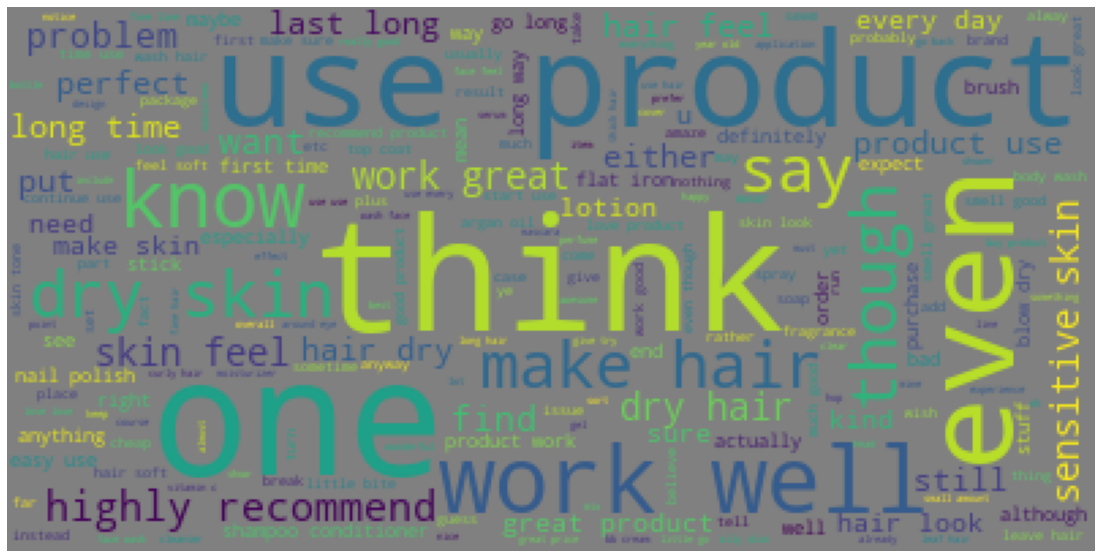

In [105]:
fig = plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(cloud)

In [106]:
beauty.head()

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime,pos_neg,processed_review
0,7806397051,Don't waste your money,Very oily and creamy. Not at all what I expect...,1.0,A1YJEY40YUW4SE,Andrea,"[3, 4]",2014-01-30,1391040000,0,oily creamy expect order try highlight contour...
1,7806397051,OK Palette!,This palette was a decent price and I was look...,3.0,A60XNB876KYML,Jessica H.,"[1, 1]",2014-04-18,1397779200,0,palette decent price look different shade pale...
2,7806397051,great quality,The texture of this concealer pallet is fantas...,4.0,A3G6XNM240RMWA,Karen,"[0, 1]",2013-09-06,1378425600,1,texture concealer pallet fantastic great cover...
3,7806397051,Do not work on my face,I really can't tell what exactly this thing is...,2.0,A1PQFP6SAJ6D80,Norah,"[2, 2]",2013-12-08,1386460800,0,really tell exactly thing powder kind oil ish ...
4,7806397051,It's okay.,"It was a little smaller than I expected, but t...",3.0,A38FVHZTNQ271F,Nova Amor,"[0, 0]",2013-10-19,1382140800,0,little small expect okay last long time think ...


### Insert `pos_neg` column for Sentiment modeling

         Negative reviews:      1-3 Stars  = 0
         Positive reviews:      4-5 Stars  = 1

   ![star](img/amazon-stars.png)

In [109]:
beauty['pos_neg'] = [1 if x > 3 else 0 for x in beauty.overall]

In [110]:
beauty.head(3)

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime,pos_neg,processed_review
0,7806397051,Don't waste your money,Very oily and creamy. Not at all what I expect...,1.0,A1YJEY40YUW4SE,Andrea,"[3, 4]",2014-01-30,1391040000,0,oily creamy expect order try highlight contour...
1,7806397051,OK Palette!,This palette was a decent price and I was look...,3.0,A60XNB876KYML,Jessica H.,"[1, 1]",2014-04-18,1397779200,0,palette decent price look different shade pale...
2,7806397051,great quality,The texture of this concealer pallet is fantas...,4.0,A3G6XNM240RMWA,Karen,"[0, 1]",2013-09-06,1378425600,1,texture concealer pallet fantastic great cover...


In [88]:
beauty['pos_neg'].value_counts()

1    154272
0     44230
Name: pos_neg, dtype: int64

In [113]:
beauty2 = beauty[["pos_neg","processed_review"]]
beauty2.groupby('pos_neg').describe()

processed_review                   
                   count  unique   top freq
pos_neg                                    
0                  44230   44173  work   11
1                 154272  153928  love   34

---
# Part II Modeling
---
## Model data

> **[ 1 ]** CountVectorizer - Multinomial NB

> **[ 2 ]** TfidfVectorizer

            1. with Logistic Regression
            2. with Linear SVM by using SGD
            3. Pipeline and GridSearch
            
> **[ 3 ]** Word2Vec

           1. Random Forest
           2. Logistic Regression

> **[ 4 ]** LSTM

            1. Simple LSTM
            2. LSTM with Word2Vec
            
            
> **[ 5 ]** Clustering / Topic Modeling (NMF and LDA)  with TF and TFIDF
          






### Train/Test Split

In [ ]:
review_text = beauty["processed_review"]

In [114]:
x_train, x_test, y_train, y_test = train_test_split(beauty.processed_review, beauty.pos_neg, random_state=0)

In [115]:
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (148876,)
y_train shape: (148876,)

x_test shape: (49626,)
y_test shape: (49626,)



In [116]:
x_train

41325     question rogaine work need start use lose hair...
35450     price guess really complain perfume smell stro...
112087    polish great really really smelly perfect cove...
97533     eh thank love pale pink hue lip treatment saw ...
31285                              good healthy strong nail
                                ...                        
152315    product difficult use attachements hard put tu...
176963    skin problem blackhead pimple area need improv...
117952    well love wear eyelash throughout day go try y...
173685    something really wrong brush build liquid thic...
43567     first time use product burn eye eye bloodshot ...
Name: processed_review, Length: 148876, dtype: object

## `CountVectorizer`

## CountVectorizer with Multinomial Naive Bayes (Benchmark Model)

Now as we have cleaned all reviews the next step is converting the reviews into numerical representations for a machine learning algorithm.

We will use CountVectorizer which implements both tokenization and occurrence counting in a single class provided by the Sklearn library. The output is a sparse matrix representation of the document.

In [117]:
# Vectorize X_train
vectorizer = CountVectorizer(min_df=5).fit(x_train)
X_train = vectorizer.transform(x_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<148876x13630 sparse matrix of type '<class 'numpy.int64'>'
	with 5015799 stored elements in Compressed Sparse Row format>


In [118]:
feature_names = vectorizer.get_feature_names()
print("Number of features: {}".format(len(feature_names)))

Number of features: 13630


In [120]:
print("Show some feature names : \n", vectorizer.get_feature_names()[::1000])

Show some feature names : 
 ['aa', 'bbw', 'choke', 'definately', 'estimation', 'glittery', 'infestation', 'lpmp', 'nix', 'plaque', 'repetitive', 'slippage', 'terra', 'vetiver']


In [138]:
scores = cross_val_score(MultinomialNB(), X_train, y_train, cv=5)

In [139]:
print("Mean cross-validation accuracy: {:.3f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.830


In [ ]:
# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

In [141]:
X_test = vectorizer.transform(x_test)

In [140]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    #print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [145]:
# Evaluate the model on validaton set
predictions = mnb.predict(X_test)
modelEvaluation(predictions)


Accuracy on validation set: 0.8344

Classification report : 
               precision    recall  f1-score   support

           0       0.64      0.59      0.61     11112
           1       0.88      0.91      0.89     38514

    accuracy                           0.83     49626
   macro avg       0.76      0.75      0.75     49626
weighted avg       0.83      0.83      0.83     49626


Confusion Matrix : 
 [[ 6513  4599]
 [ 3617 34897]]


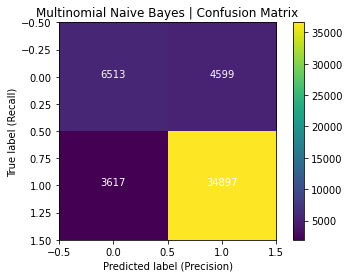

In [149]:
mnb_cfm = confusion_matrix(y_test, predictions)
plt.imshow(log_cfm, interpolation='nearest')

for i, j in itertools.product(range(mnb_cfm.shape[0]), range(mnb_cfm.shape[1])):
    plt.text(j, i, mnb_cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Multinomial Naive Bayes | Confusion Matrix')
plt.colorbar();

## TfidfVectorizer with Logistic Regression

Some words might appear quite frequently but have a very less or negligible meaningful information about the sentiment for a particular review. Instead of using occurance counting we will use tf-idf transform to scale down the impact of frequently appearing words in a given corpus.

In sklearn library we will use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.

In [150]:
# Fitting and transforming the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(x_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 13630 

Show some feature names : 
 ['aa', 'bbw', 'choke', 'definately', 'estimation', 'glittery', 'infestation', 'lpmp', 'nix', 'plaque', 'repetitive', 'slippage', 'terra', 'vetiver']


D:\Software\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [151]:
# Have a look at the top 10 features with the smallest and largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with the smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with the largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with the smallest coefficients :
['unfortunately' 'disappoint' 'waste' 'ok' 'return' 'maybe' 'okay'
 'disappointment' 'hop' 'useless']

Top 10 features with the largest coefficients : 
['love' 'great' 'highly' 'amaze' 'perfect' 'excellent' 'awesome'
 'skeptical' 'compliment' 'happy']


In [152]:
# Evaluating on the validaton set
predictions = lr.predict(tfidf.transform(x_test))
modelEvaluation(predictions)


Accuracy on validation set: 0.8572

Classification report : 
               precision    recall  f1-score   support

           0       0.76      0.53      0.63     11112
           1       0.88      0.95      0.91     38514

    accuracy                           0.86     49626
   macro avg       0.82      0.74      0.77     49626
weighted avg       0.85      0.86      0.85     49626


Confusion Matrix : 
 [[ 5935  5177]
 [ 1912 36602]]


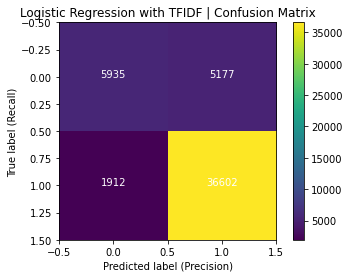

In [154]:
cfm = confusion_matrix(y_test, predictions)
plt.imshow(log_cfm, interpolation='nearest')

for i, j in itertools.product(range(cfm.shape[0]), range(cfm.shape[1])):
    plt.text(j, i, cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Logistic Regression with TFIDF | Confusion Matrix')
plt.colorbar();

## TfidfVectorizer using Linear SVM by using SGD

In [155]:
# Fitting and transforming the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(x_train)

# SVM
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2")
clf.fit(X_train_tfidf, y_train)

SGDClassifier()

In [156]:
# Have a look at the top 10 features with the smallest and largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = clf.coef_[0].argsort()
print('\nTop 10 features with the smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with the largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with the smallest coefficients :
['ok' 'unfortunately' 'okay' 'waste' 'disappoint' 'maybe' 'return' 'hop'
 'bad' 'nothing']

Top 10 features with the largest coefficients : 
['love' 'great' 'amaze' 'perfect' 'happy' 'without' 'best' 'year'
 'definitely' 'highly']


In [158]:
# Evaluating on the validaton set
predictions = clf.predict(tfidf.transform(x_test))
modelEvaluation(predictions)


Accuracy on validation set: 0.8393

Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.35      0.50     11112
           1       0.84      0.98      0.90     38514

    accuracy                           0.84     49626
   macro avg       0.84      0.67      0.70     49626
weighted avg       0.84      0.84      0.81     49626


Confusion Matrix : 
 [[ 3917  7195]
 [  781 37733]]


## Pipeline and GridSearch

We will build a pipeline in the Sklearn library to streamline the workflow and use GridSearch on the pipeline model to implement hyperparameter tuning for both the vectorizer and classifier at once

In [159]:
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(x_train, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(x_test)
modelEvaluation(predictions)

D:\Software\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The best paramenter set is : 
 {'lr__C': 10, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}

Accuracy on validation set: 0.8734

Classification report : 
               precision    recall  f1-score   support

           0       0.77      0.62      0.69     11112
           1       0.90      0.95      0.92     38514

    accuracy                           0.87     49626
   macro avg       0.83      0.78      0.80     49626
weighted avg       0.87      0.87      0.87     49626


Confusion Matrix : 
 [[ 6861  4251]
 [ 2034 36480]]


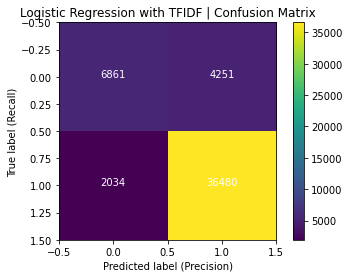

In [160]:
cfm = confusion_matrix(y_test, predictions)
plt.imshow(log_cfm, interpolation='nearest')

for i, j in itertools.product(range(cfm.shape[0]), range(cfm.shape[1])):
    plt.text(j, i, cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Logistic Regression with TFIDF | Confusion Matrix')
plt.colorbar();

## Word2Vec

Another common approach of word embedding is the prediction based embedding like Word2Vec model. Briefly, Word2Vec is a combination of two techniques: Continuous Bag of Words (CBoW) and Skip-Gram model. Both are Shallow Neural Networks which learn weights for the word vector representations.

Here, we will train Word2Vec model to create our own word vector representation using gensim library. Then we will fit the feature vectors of the reviews to the Random Forest Classifier. Here's the workflow of this part: -

Parse review text to sentences (Word2Vec model takes a list of sentences as inputs).
Create vocabulary list using Word2Vec model.
Transform each review into numerical representation by computing average feature vectors of words therein
Fit the average feature vectors to Random Forest Classifier
Parsing Review into Sentences

Word2Vec model takes a list of sentences as inputs and outputs word vector representations for words in the vocabulary list created. Before we train the Word2Vec model, we have to parse reviews in the training set into sentences.

In [161]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aashi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [182]:
from bs4 import BeautifulSoup 
import re
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [183]:
# Splitting review text into parsed sentences using NLTK's punkt tokenizer

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences


# Parsing each review in the training set into sentences
sentences = []
for review in x_train:
    sentences += parseSent(review, tokenizer)
    
print('%d parsed sentence in the training set\n'  %len(sentences))
print('Show a parsed sentence in the training set : \n',  sentences[10])


148851 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['make', 'makeup', 'go', 'smooth', 'seem', 'tame', 'line', 'bite', 'crazy', 'smell', 'though', 'smell', 'kind', 'toxic']


In [164]:
from gensim.models import Word2Vec
w2v = Word2Vec()


Creating Vocabulary List using Word2Vec Model

As we have a set of cleaned and parsed sentences from the training data, we will train our own word vector representations by specifying the embedding dimension (= length of feature vector).

In [170]:
x_train

41325     question rogaine work need start use lose hair...
35450     price guess really complain perfume smell stro...
112087    polish great really really smelly perfect cove...
97533     eh thank love pale pink hue lip treatment saw ...
31285                              good healthy strong nail
                                ...                        
152315    product difficult use attachements hard put tu...
176963    skin problem blackhead pimple area need improv...
117952    well love wear eyelash throughout day go try y...
173685    something really wrong brush build liquid thic...
43567     first time use product burn eye eye bloodshot ...
Name: processed_review, Length: 148876, dtype: object

In [185]:
# Fitting parsed sentences to Word2Vec model 

num_features = 100  #embedding dimension                     
min_word_count = 5                
num_workers = 4       
context = 5                                                                                          
downsampling = 1e-3 

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,
                window = context)
w2v.init_sims(replace=True)
w2v.save("w2v_300features_10minwordcounts_10context") #save trained word2vec model

print("Number of words in the vocabulary list : %d \n" %len(w2v.wv.index2word)) #4016 
print("Show first 10 words in the vocabulary list  vocabulary list: \n", w2v.wv.index2word[0:10])

Training Word2Vec model ...

Number of words in the vocabulary list : 14323 

Show first 10 words in the vocabulary list  vocabulary list: 
 ['use', 'hair', 'product', 'like', 'skin', 'get', 'good', 'look', 'one', 'make']


### Averaging Feature Vectors

Now we have created a vocabulary list of words with each word having a word representation(ie. feature vector of dim 300).

To find a numerical representation for a review, we run through each word in a review text. For words appear in the vocabulary list, we compute the average feature vectors of all those words. The average feature vector is the numerical represenation of the review.

In [187]:
# Transfroming the training data into feature vectors

def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words 
    appeared in that review and in the vocabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word) #index2word is the vocabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [188]:
trainVector = getAvgFeatureVecs(x_train, w2v, num_features)

<ipython-input-187-46b6f43eb48b>:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  featureVec = np.add(featureVec, model[word])


In [189]:
print("Training set : %d feature vectors with %d dimensions" %trainVector.shape)

Training set : 148876 feature vectors with 100 dimensions


In [190]:
testVector = getAvgFeatureVecs(x_test, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" %testVector.shape)

<ipython-input-187-46b6f43eb48b>:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  featureVec = np.add(featureVec, model[word])


Validation set : 49626 feature vectors with 100 dimensions


In [192]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)


Accuracy on validation set: 0.7757

Classification report : 
               precision    recall  f1-score   support

           0       0.48      0.02      0.04     11112
           1       0.78      0.99      0.87     38514

    accuracy                           0.78     49626
   macro avg       0.63      0.51      0.46     49626
weighted avg       0.71      0.78      0.69     49626


Confusion Matrix : 
 [[  235 10877]
 [  252 38262]]


In [246]:
lr = LogisticRegression()
lr.fit(trainVector, y_train)
predictions = lr.predict(testVector)
modelEvaluation(predictions)


Accuracy on validation set: 0.7763

Classification report : 
               precision    recall  f1-score   support

           0       0.62      0.00      0.01     11112
           1       0.78      1.00      0.87     38514

    accuracy                           0.78     49626
   macro avg       0.70      0.50      0.44     49626
weighted avg       0.74      0.78      0.68     49626


Confusion Matrix : 
 [[   31 11081]
 [   19 38495]]



## Applying LSTM

Long Short Term Memory(LSTM) Networks are a special kind of the Recurrent Neural Networks(RNN) capable of learning long-term dependencies. LSTM can be very useful in text mining problems as it involves dependencies in the sentences which can be caught in the "memory" of the LSTM. Here, we will train a simple LSTM and LSTM with Word2Vec embedding for classifying the reviews into positive and negative sentiments using Keras library.

## Simple LSTM

We need to preprocess the text data to 2D tensor before we begin fitting it into a simple LSTM. Firstly we will tokenize the corpus by considering only top words (top_words = 20000) and transforming reviews to numerical sequences using the trained tokenizer. Lastly we will make it sure that all the numerical sequences have the same length (maxlen=100) for modelling by truncating the long reviews and padding shorter reviews having zero values.

For constructing a simple LSTM, we will use embedding class in Keras to building up the first layer. This embedding layer converts numerical sequence of words into a word embedding. We should also note that the embedding class provides a convenient way to map discrete words into a continuous vector space but it doesn't take the semantic similarity of the words into account. The next layer is the LSTM layer with 128 memory units. Finally, we will use a dense output layer with a single neuron and a sigmoid activation function to make 0 or 1 prediction for the two classes (positive sentiment and negative sentiment). As it is a binary classification problem log loss is used as the loss function(binary_crossentropy in Keras). ADAM optimization algorithm will be used.

Here's the workflow in this part: -

Prepare X_train and X_test to 2D tensor.
Train a simple LSTM (embedding layer => LSTM layer => dense layer).
Compile and fit the model using log loss function and ADAM optimizer

In [205]:
top_words = 20000 
maxlen = 100 
batch_size = 32
nb_classes = 3
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #Considering only top 20000 words in the corpus




In [209]:
tokenizer.fit_on_texts(x_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer


sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

# One-Hot Encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)



In [212]:
print('X_train shape:', X_train_seq.shape)
print('X_test shape:', X_test_seq.shape) 
print('y_train shape:', y_train_seq.shape) 
print('y_test shape:', y_test_seq.shape) 

X_train shape: (148876, 100)
X_test shape: (49626, 100)
y_train shape: (148876,)
y_test shape: (49626,)


In [219]:
X_train_seq

array([[   0,    0,    0, ...,  794,   43, 3437],
       [   0,    0,    0, ...,  258,   28, 3742],
       [   0,    0,    0, ...,  449,   73,    3],
       ...,
       [   0,    0,    0, ...,  319,  117,   23],
       [   0,    0,    0, ...,  567,  235,  442],
       [   0,    0,    0, ...,  174, 1301,  314]])

In [247]:
# Constructing a Simple LSTM
model1 = Sequential()
model1.add(Embedding(top_words, 128))
model1.add(LSTM(128)) 
model1.add(Dropout(0.2))
model1.add(Dense(nb_classes))
model1.add(Activation('softmax'))
model1.summary()

# Compiling LSTM
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)

# Model Evaluation
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 128)         1833344   
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_7 (Activation)    (None, 3)                 0         
Total params: 1,965,315
Trainable params: 1,965,315
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
4653/4653 [==============================] - 664s 143ms/step - loss: 0.2359 - accuracy: 0.8462
Epoc

## LSTM with Word2Vec Embedding

In the simple LSTM model constructed above, the embedding class in Keras comes in handy for converting the numerical sequence of words into a word embedding but it doesn't take the semantic similarity of the words into account. The model assigns random weights to the embedding layer and learn the embeddings by minimizing the global error of the network.

Instead of using random weights we will use pretrained word embeddings for initializing the weight of an embedding layer. Here, we will use the Word2Vec embedding trained in Part 4 for intializing the weights of embedding layer in LSTM.

Load pretrained word embedding model.
Construct embedding layer using embedding matrix as weights.
Train a LSTM with Word2Vec embedding (embedding layer => LSTM layer => dense layer).
Compile and fit the model using log loss function and ADAM optimizer.

In [221]:
w2v = Word2Vec.load("w2v_300features_10minwordcounts_10context")


# Getting Word2Vec embedding matrix
embedding_matrix = w2v.wv.syn0  # embedding matrix, type = numpy.ndarray 
print("Shape of embedding matrix : ", embedding_matrix.shape) #(4016, 300) = (vocabulary size, embedding dimension)
# w2v.wv.syn0[0] #feature vector of the first word in the vocabulary list

Shape of embedding matrix :  (14323, 100)


<ipython-input-221-24182a96004a>:5: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  embedding_matrix = w2v.wv.syn0  # embedding matrix, type = numpy.ndarray


In [222]:
top_words = embedding_matrix.shape[0]
maxlen = 100 
batch_size = 32
nb_classes = 3
nb_epoch = 3


# Vectorizing X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #Considering only top 20000 words in the corpus
tokenizer.fit_on_texts(x_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# One-Hot Encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) 
print('X_test shape:', X_test_seq.shape) 
print('y_train shape:', y_train_seq.shape)
print('y_test shape:', y_test_seq.shape) 

D:\Software\envs\myenv\lib\site-packages\keras_preprocessing\text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


X_train shape: (148876, 100)
X_test shape: (49626, 100)
y_train shape: (148876, 3)
y_test shape: (49626, 3)


In [224]:
# Constructing Word2Vec embedding layer
embedding_layer = Embedding(embedding_matrix.shape[0], #4016
                            embedding_matrix.shape[1], #300
                            weights=[embedding_matrix])


# Constructing LSTM with Word2Vec embedding
model2 = Sequential()
model2.add(embedding_layer)
model2.add(LSTM(128)) 
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))
model2.summary()

# Compiling model
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)


# Model evaluation
score = model2.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         1432300   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_4 (Activation)    (None, 3)                 0         
Total params: 1,549,935
Trainable params: 1,549,935
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
4653/4653 [==============================] - 556s 120ms/step - loss: 0.2353 - accuracy: 0.8455
Epoch 2/3
4653/4653 [==============================] - 560s 120ms/step - loss: 0.1933 - accuracy: 0.8766
Epoch 3/3
1551/1551 [===========

### Summary:

* Pipleline and GridSearch CV with Logistic Regression has the highest accuarcy of 87% and works best for classifying product   sentiments

* LSTM with Word2Vec is the second best with 86% Accuracy

* Take aways - Word embedding with TFIDF work best for our use case

---

# Clustering / Topic Modeling (NMF and LDA)

---
## Clustering Vectorize:
### `CountVectorizer` & `Tf-idf`


* With NLTK stopwords 

In [227]:
# Use tf-idf features
tfidf_vectorizer = TfidfVectorizer(stop_words=stops)
tfidf = tfidf_vectorizer.fit_transform(review_text)

# Use tf features
tf_vectorizer = CountVectorizer(stop_words=stops)
tf = tf_vectorizer.fit_transform(review_text)

In [228]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print("Number of total features: {}".format(len(tfidf_feature_names)))

Number of total features: 77874


---
## Build Clustering Models:
## `Nonnegative Matrix Factorization (NMF)` 
### & 
## `Latent Dirichlet Allocation (Lda)`

In [231]:
# Initialize NMF
nmf = NMF(n_components=10, random_state=1,
          alpha=.1, l1_ratio=.5)

# Initialize Ida
lda = LatentDirichletAllocation(n_components=10, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [232]:
num_top_words = 15

def retrieve_top_words(model, feature_names, num_top_words):
    for idx, topic in enumerate(model.components_):
        print("Topic #{}:".format(idx), end='\n')
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]), end='\n\n')
    print()

## `Term frequency` [ tf ]

## NMF

In [233]:
nmf_tf = nmf.fit(tf)

D:\Software\envs\myenv\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [234]:
nmf_ = nmf_tf.transform(tf)
Counter([np.argmax(i) for i in nmf_])

Counter({8: 39131,
         2: 18734,
         6: 4898,
         1: 32365,
         3: 21487,
         4: 23146,
         7: 7988,
         0: 25972,
         5: 15660,
         9: 9121})

In [ ]:
tfidf_feature_names

In [235]:
retrieve_top_words(nmf_tf, tfidf_feature_names, num_top_words)

Topic #0:
hair dry iron long thick used dryer conditioner color curly flat heat time blow ends

Topic #1:
skin face dry using cream sensitive moisturizer acne products oily feel also lotion used serum

Topic #2:
use face using every day wash easy also need get week time night make works

Topic #3:
product products using would used great recommend results good review bottle however say try price

Topic #4:
like really smell feel scent smells nice look good color lotion feels would little body

Topic #5:
nail color polish nails gel coat top light apply gelish colors time led uv dry

Topic #6:
oil argan bottle oils also natural ingredients used organic coconut pure water vitamin dry drops

Topic #7:
shampoo conditioner products scalp scent using hair good well clean smell shampoos used bottle great

Topic #8:
one get would really good well time used much great little even love long also

Topic #9:
brush brushes great bristles foundation love makeup soft set powder well apply quality price

### NMF / tf Topics



Topic #0: **[ Hair Styling ]**

hair dry iron long thick used dryer conditioner color curly flat heat time blow ends

Topic #1: **[ Skin Care ]**

skin face dry using cream sensitive moisturizer acne products oily feel also lotion used serum

Topic #2: **[ Face wash ]**

use face using every day wash easy also need get week time night make works

Topic #3: **[ Positive Review ]**

product products using would used great recommend results good review bottle however say try price

Topic #4: **[ Scented Lotion ]**

like really smell feel scent smells nice look good color lotion feels would little body

Topic #5: **[ Nail Polish ]**

nail color polish nails gel coat top light apply gelish colors time led uv dry

Topic #6: **[Oil ]**

oil argan bottle oils also natural ingredients used organic coconut pure water vitamin dry drops

Topic #7: **[Shampoo ]**

shampoo conditioner products scalp scent using hair good well clean smell shampoos used bottle great

Topic #8: **[ Positive Review ]**

one get would really good well time used much great little even love long also

Topic #9: **[Brush ]**

brush brushes great bristles foundation love makeup soft set powder well apply quality price good



## Lda

In [237]:
lda_tf = lda.fit(tf)

In [238]:
lda_ = lda_tf.transform(tf)
Counter([np.argmax(i) for i in lda_])

Counter({4: 129242,
         0: 25639,
         6: 19085,
         9: 16499,
         1: 521,
         3: 2630,
         5: 1265,
         2: 3120,
         8: 208,
         7: 293})

In [239]:
retrieve_top_words(lda_tf, tfidf_feature_names, num_top_words)

Topic #0:
color like colors love look really great looks dark one light would pretty nice pink

Topic #1:
nail nails polish coat polishes gelish wen manicure split balm cuticles cellulite acrylic opi purse

Topic #2:
brush mascara lashes use get mirror easy one bag razor apply remove make top eyeliner

Topic #3:
makeup eyes eye foundation love powder set bb wear look make like primer coverage circles

Topic #4:
product skin use like using face really used good one products would well dry feel

Topic #5:
oil scent vitamin argan natural ingredients smell oils bottle organic butter water body fragrance shea

Topic #6:
hair use dry conditioner product like iron long thick flat fine soft used heat get

Topic #7:
skin sensitive sunscreen 8217 sun acid spf moisturizer dead sea free ingredients peel hyaluronic aging

Topic #8:
shampoo conditioner soap wash clean shower scalp body suave shampoos axe husband men dandruff conditioners

Topic #9:
great price good brushes one quality well love woul

### Lda / tf Topics
 
Topic #0: **[ Color ]**

color like colors love look really great looks dark one light would pretty nice pink

Topic #1: **[ Nail Polish ]**

nail nails polish coat polishes gelish wen manicure split balm cuticles cellulite acrylic opi purse

Topic #2: **[ Eye makeup ]**

brush mascara lashes use get mirror easy one bag razor apply remove make top eyeliner

Topic #3: **[ Eye makeup ]**

makeup eyes eye foundation love powder set bb wear look make like primer coverage circles

Topic #4: **[ Skin care ]**

product skin use like using face really used good one products would well dry feel

Topic #5: **[ Oil ]**

oil scent vitamin argan natural ingredients smell oils bottle organic butter water body fragrance shea

Topic #6: **[ Hair Styling/ Care]**

hair use dry conditioner product like iron long thick flat fine soft used heat get

Topic #7: **[ Skin/Sunscreen ]**

skin sensitive sunscreen 8217 sun acid spf moisturizer dead sea free ingredients peel hyaluronic aging

Topic #8: **[ Hair Shampoo ]**

shampoo conditioner soap wash clean shower scalp body suave shampoos axe husband men dandruff conditioners

Topic #9: **[ Nice Brush ]**

great price good brushes one quality well love would buy size really nice get recommend

## `Term frequency-inverse document frequency` [ tfidf ]

## NMF

In [240]:
nmf_tfidf = nmf.fit(tfidf)

In [241]:
nmf_W = nmf_tfidf.transform(tfidf)
Counter([np.argmax(i) for i in nmf_W])

Counter({5: 51017,
         4: 11514,
         6: 12770,
         2: 14179,
         0: 33256,
         8: 12309,
         9: 10721,
         1: 28564,
         7: 13721,
         3: 10451})

In [242]:
retrieve_top_words(nmf_tfidf, tfidf_feature_names, num_top_words)

Topic #0:
skin face dry use sensitive using cream oily moisturizer oil acne feel lotion feels feeling

Topic #1:
hair dry use oil curly thick iron fine soft dryer flat conditioner blow long leave

Topic #2:
color colors pink dark looks red nice light brown pretty beautiful lipstick lips lip shade

Topic #3:
brush brushes bristles foundation set soft makeup quality powder use blush sigma perfect good shed

Topic #4:
great price works smells buy well quality colors good easy really recommend deal looks value

Topic #5:
like one really good get use time would little well much long used smell 34

Topic #6:
product recommend would using good products used results highly see use definitely purchase anyone difference

Topic #7:
nail polish nails coat top art gel polishes base designs colors coats use opi manicure

Topic #8:
love colors makes smell absolutely soft amazing stuff perfect buy recommend smells use way one

Topic #9:
shampoo conditioner scent clean smell scalp nice smells shampoos 

### NMF / tfidf Topics

Topic #0: **[ Skin care ]**

skin face dry use sensitive using cream oily moisturizer oil acne feel lotion feels feeling

Topic #1: **[ Hair Shampoo/ Styling ]**

hair dry use oil curly thick iron fine soft dryer flat conditioner blow long leave

Topic #2: **[ Lipstick ]**

color colors pink dark looks red nice light brown pretty beautiful lipstick lips lip shade

Topic #3: **[ Brushes ]**

brush brushes bristles foundation set soft makeup quality powder use blush sigma perfect good shed

Topic #4: **[ Positive review ]**

great price works smells buy well quality colors good easy really recommend deal looks value

Topic #5: **[ ?? ]**

like one really good get use time would little well much long used smell 34

Topic #6: **[ Brushes ]**

product recommend would using good products used results highly see use definitely purchase anyone difference

Topic #7: **[ Nail ]**

nail polish nails coat top art gel polishes base designs colors coats use opi manicure

Topic #8: **[ Positive review ]**

love colors makes smell absolutely soft amazing stuff perfect buy recommend smells use way one

Topic #9: **[ Shampoo ]**

shampoo conditioner scent clean smell scalp nice smells shampoos dandruff hair like leaves soft feeling

## Lda

In [243]:
lda_tfidf = lda.fit(tfidf)

In [244]:
lda_W = lda_tfidf.transform(tfidf)
Counter([np.argmax(i) for i in lda_W])

Counter({6: 197916,
         0: 58,
         9: 45,
         7: 114,
         8: 70,
         3: 56,
         2: 13,
         5: 160,
         4: 43,
         1: 27})

In [245]:
retrieve_top_words(lda_tfidf, tfidf_feature_names, num_top_words)

Topic #0:
wigs granddaughter wall temp expressed motion spiked costume 8226 com http www mechanism outfit install

Topic #1:
palette highlighter wheel clippers clipper dupe coastal evaluation decently friday realy pallette distributes bones bh

Topic #2:
bows contour receiving smokey fog adhesive adjustable pairs husbands decorate arent turquoise disposables guards josie

Topic #3:
polish nail nails polishes gelish opi stamp shellac stamper konad essie acetone top cnd chipping

Topic #4:
tape rhinestones disappoint combing palettes peace ur cheeky crystals holo weighted orchid pockets defiantly leather

Topic #5:
slides smoky austin se collections musk spouse resealable physicians fantasy texturizing intoxicating sensational de camouflage

Topic #6:
hair product skin like use great love really good one well would using color used

Topic #7:
stones flowers ingredients sodium flower caffeine extract toni oxygen ingredient blossom zinc titanium oxide infusing

Topic #8:
neat organized bli

### Lda / tfidf Topics

Topic #0: **[ ?? ]**

wigs granddaughter wall temp expressed motion spiked costume 8226 com http www mechanism outfit install

Topic #1: **[ palette ?? ]**

palette highlighter wheel clippers clipper dupe coastal evaluation decently friday realy pallette distributes bones bh

Topic #2: **[ ?? ]**

bows contour receiving smokey fog adhesive adjustable pairs husbands decorate arent turquoise disposables guards josie

Topic #3: **[ Nail ]**

polish nail nails polishes gelish opi stamp shellac stamper konad essie acetone top cnd chipping

Topic #4: **[ ?? ]**

tape rhinestones disappoint combing palettes peace ur cheeky crystals holo weighted orchid pockets defiantly leather

Topic #5: **[ Positiove Review ]**

slides smoky austin se collections musk spouse resealable physicians fantasy texturizing intoxicating sensational de camouflage

Topic #6: **[ Positive review ]**

hair product skin like use great love really good one well would using color used

Topic #7: **[ Powder?? ]**

stones flowers ingredients sodium flower caffeine extract toni oxygen ingredient blossom zinc titanium oxide infusing

Topic #8: **[ Decor ]**

neat organized bling functional lotus organix accessory magnet discs cools managable wire english hrs decorations

Topic #9: **[ Hair Styling ]**

iron curling flat heat clips straightener heats curl razors curls curler rollers remington temperature hot

### Summary:

* Both **NMF with tf and tfidf** were about the same and performed quite well.
* **Lda with tf** was the best. It had a lot of meaningful and unquie associations 

* **Lda with tfidf** primarily consisted of unassociated words. However - it did accuractely asscoiate a brand with product --> remington for hair styling

### Further Application/Productization:
* `Recommendation Engine: Collaborative filtering & Factorization Machine`
* Scraping `Nykaa` and/or other beauty ecommerce sites in order to build a better, more robust `Recommendation Engine`  -- to reach the goal of a **Recommendation Engine Chatbot for Beauty Products** (for say Facebook or Slack)